# Loading the Data

In [13]:
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import numpy as np
import string
import re

from typing import Tuple
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# You may have to do this to get this project to run
# import nltk
# nltk.download()

In [3]:
train = pd.read_csv('train.csv', names=['target', 'text', 'description'])
test = pd.read_csv('test.csv', names=['target', 'text', 'description'])

train.head()

,target,text,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
def preprocess(data: pd.Series) -> pd.Series:
    """ Performs the following actions:
            1. Removes all punctionation
            2. Removes stop words and common words
            3. Removes symbols
            4. Removes URLs
            5. Remove numbers
    """
    text = data
    text = _remove_url(text)
    text = _remove_non_chars(text)
    text = _remove_stopwords(text)
    return text
    
def _remove_url(column: pd.Series) -> pd.Series:
    """ Removes all URLs from the data """
    url_match = re.compile("https?:\/\/\S+")
    return column.apply(lambda x: re.sub(url_match, " ", x))
    
def _remove_non_chars(column: pd.Series) -> pd.Series:
    """ Removes all non-characters from the string, including punctionation and numbers """
    char_match = re.compile("[^a-z\s\']+")
    return column.apply(lambda x: re.sub(char_match, " ", x.lower()).replace("'", ""))

def _remove_stopwords(column: pd.Series) -> pd.Series:
    """ Removes stopwords """
    words = set(stopwords.words('english'))    
    return column.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in words]))

In [5]:
train['text'] = preprocess(train['text'])
train.head()

,target,text,description
0,3,wall st bears claw back black reuters,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,carlyle looks toward commercial aerospace reuters,Reuters - Private investment firm Carlyle Grou...
2,3,oil economy cloud stocks outlook reuters,Reuters - Soaring crude prices plus worries\ab...
3,3,iraq halts oil exports main southern pipeline ...,Reuters - Authorities have halted oil export\f...
4,3,oil prices soar time record posing new menace ...,"AFP - Tearaway world oil prices, toppling reco..."


In [6]:
test['text'] = preprocess(test['text'])
test.head()

,target,text,description
0,3,fears n pension talks,Unions representing workers at Turner Newall...
1,4,race second private team sets launch date huma...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,ky company wins grant study peptides ap,AP - A company founded by a chemistry research...
3,4,prediction unit helps forecast wildfires ap,AP - It's barely dawn when Mike Fitzpatrick st...
4,4,calif aims limit farm related smog ap,AP - Southern California's smog-fighting agenc...


In [7]:
def get_top_per_class(data: pd.DataFrame, group: str, col: str, per: int = 1100) -> set:
    """ Gets the top per words from each class and returns the total vocab, in no particular order """
    vocab = set()
    for group, frame in train.groupby(group):
        class_vocab = []
        [class_vocab.extend(word_tokenize(x)) for x in frame[col]]
        freq = FreqDist(class_vocab)
        vocab.update(sorted(freq, key=freq.get)[:per])
    return vocab

In [8]:
top = get_top_per_class(train, 'target', 'text')
len(top)

4271

In [9]:
vectorizer = TfidfVectorizer(vocabulary=top)
x_train = vectorizer.fit_transform(train['text'])
y_train = np.array(train['target'])
x_train.shape, y_train.shape

((120000, 4271), (120000,))

In [10]:
x_test = vectorizer.transform(test['text'])
y_test = np.array(test['target'])
x_test.shape, y_test.shape

((7600, 4271), (7600,))

In [11]:
features = set(vectorizer.get_feature_names())
assert len(features - top) == 0  # No features outside the vocabulary

## Logistic Regression

Objective Function: $J (w; X, y) = -\frac{1}{N} \sum_{i=1}^n \sum_{k=1}^k y_{ik} \log \Big( \frac{\exp(f_k)}{\sum_c \exp( f_c)} \Big) + \lambda \| w \|_2^2 $.

Gradient: $\frac{\delta J}{\delta w_k} = \frac{1}{N} \sum_{i=1}^n x_i \Big(\frac{\exp(f_k)}{\sum_c \exp( f_c)} - y_i \Big) + 2 \lambda w_k $

In [19]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

class LogisticRegression:
    
    def __init__(self, learning_rate: float, max_epochs: int = 1000, precision: float = 1E-6, 
                 lam: float = 1E-6, optimizer: str = 'sgd', batch_size: int = None):
        """ Initializes the class """
        self.rate = learning_rate
        self.epochs = max_epochs
        self.precision = precision
        self.lambda_ = lam
        self.b_ = batch_size
        self.alg_ = self._set_optimizer(optimizer)
        self.loss_ = None
        self.w_ = None
        
    def _set_optimizer(self, optimizer: str):
        """ Sets the optimizer """
        optimizer = optimizer.lower().strip()
        if optimizer == 'sgd':
            return self._stochastic_descent
        elif optimizer == 'mbsgd':
            if not self.b_:
                raise ValueError("You must declare a batch size with 'batch_size' in order to use " \
                                 "mini-batch stochastic gradient descent")
            return self._mb_stochastic_descent
        else:
            raise ValueError(f"Optimizer must be of value 'sgd' or 'mbsgd'. The value {optimizer} is not valid")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Predicts the class of the input array """
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))
        return np.argmax(self._softmax_batch(X.dot(self.w_)), axis=1)
    
    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Scores how well the Logistic model predicts """
        correct = 0.0
        X = self._insert_bias(X)
        labels = self.predict(X)
        for i, label in enumerate(labels):
            correct += int(label == y[i])
        return correct / len(y)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """ Fits the model to the training data """
        X, y = self._bootstrap(X, y)
        self.loss_ = list()
        for i in range(self.epochs):
            n, d = X.shape
            rand_indices = np.random.permutation(n)
            xi = X[rand_indices, :]
            yi = y[rand_indices, :]
            
            if self.w_ is None:
                self.w_ = np.random.random((d, yi.shape[1]))  # d x k matrix
            
            loss = self.alg_(xi, yi)
            self.loss_.append(loss)
            
            if i > 0 and abs(self.loss_[i-1] - loss) <= self.precision:
                print(f"Precision reached at epoch {i}")
                break
                
            self.rate *= 0.9
            
    def plot(self) -> None:
        """ Plots the loss """
        epochs = len(self.loss_)
        fig = plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.loss_)
        plt.title('Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    
    def _bootstrap(self, X, y: np.ndarray) -> None:
        """ Initializes a random weight and bias for the input data """
        X = self._insert_bias(X)  # Inserts the bias
        y = self._one_hot(y)  # one hot encode the classes
        return X, y
    
    @staticmethod
    def _insert_bias(X):
        """ Inserts the bias """
        bias = np.ones((X.shape[0], 1))
        if isinstance(X, scipy.sparse.csr.csr_matrix):
            X = np.concatenate((X.todense(), bias), axis=1)  # Insert bias into the features
            X = csr_matrix(X)
        else:
            X = np.concatenate((X, bias), axis=1)
        return X
        
    def _one_hot(self, y: np.ndarray)-> np.ndarray:
        """ One hot encodes the targets """
        unique = sorted(np.unique(y))
        onehot = np.zeros((y.shape[0], len(unique)))
        for idx, val in enumerate(y):
            cls_idx = unique.index(val)
            onehot[idx][cls_idx] = 1
        return onehot
        
    def _stochastic_descent(self, xi: np.ndarray, yi: np.ndarray) -> float:
        """ Implementation of stochastic gradient descent """
        n, d = xi.shape
        epoch_loss = 0.
        for k in range(n):
            x = xi[k, :]
            y = yi[k, :]
            loss, g = self._stochastic_gradient(x, y)
            epoch_loss += loss
            self.w_ -= self.rate * g
        return -epoch_loss / n
        
    def _stochastic_gradient(self, x: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """ Computes the stochastic gradient and its loss """
        if len(x.shape) == 1:
            x = x.reshape((1, x.shape[0]))  # 1 x d vector
        if len(y.shape) == 1:
            y = y.reshape((1, y.shape[0]))  # 1 x k vector
        
        phi = x.dot(self.w_)  # 1 x k vector
        softmax = self._softmax(phi)  # 1 x k vector
        loss = np.sum(np.multiply(y, np.log(softmax))) + (self.lambda_ * np.sum(np.square(self.w_)))  # scalar     
        g = (x.T.dot(softmax - y)) + (2 * self.lambda_ * self.w_) # d x k matrix
        return loss, g
    
    @staticmethod
    def _softmax(phi: np.ndarray) -> np.ndarray:
        """ Solves the softmax function """
        exps = np.exp(phi)
        return exps / np.sum(exps)  # k x 1 matrix

    def _mb_stochastic_descent(self, xi: np.ndarray, yi: np.ndarray) -> float:
        """ Implementation of stochastic gradient descent """
        n, d = xi.shape
        iters = int(n / self.b_)
        epoch_loss = 0.
        start = 0
        for k in range(iters):
            end = start + self.b_
            x = xi[start:end, :]
            y = yi[start:end, :]
            loss, g = self._mb_stochastic_gradient(x, y)
            epoch_loss += loss
            self.w_ -= self.rate * g
            start = end
        return -epoch_loss / iters
        
    def _mb_stochastic_gradient(self, x: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:
        """ Computes the mini-batch stochastic gradient and its loss """
        phi = x.dot(self.w_)  # b x k matrix
        softmax = self._softmax_batch(phi)  # b x k matrix
        
        loss = (1 / self.b_) * np.sum(np.multiply(y, np.log(softmax))) 
        loss += self.lambda_ * np.sum(np.square(self.w_))  # scalar
        
        g = (1 / self.b_) * ((x.T.dot(softmax - y)) + (2 * self.lambda_ * self.w_))
        return loss, g

    @staticmethod
    def _softmax_batch(phi: np.ndarray) -> np.ndarray:
        """ Defines row-wise softmax """
        n, d = phi.shape
        exps = np.exp(phi)
        denom = (1 / np.sum(exps, axis=1)).reshape((n, 1))
        return np.multiply(denom, exps)

In [20]:
log = LogisticRegression(0.1, optimizer='mbsgd', batch_size=50, max_epochs=100)
log.fit(x_train, y_train)

Precision reached at epoch 77


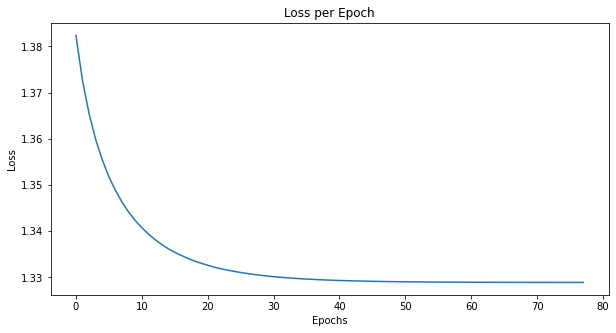

(0.21799166666666667, None)

In [21]:
log.score(x_train, y_train), log.plot()

In [15]:
log2 = LogisticRegression(0.1, max_epochs=10)
log2.fit(x_train, y_train)

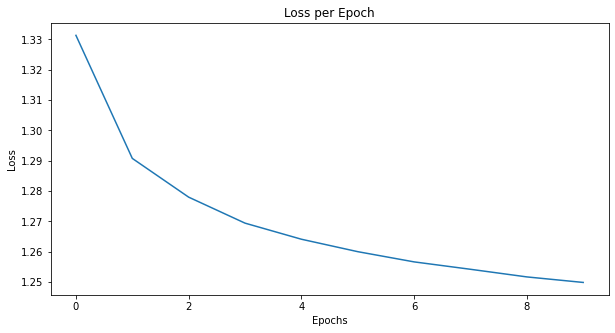

(0.2186, None)

In [18]:
log2.score(x_train, y_train), log2.plot()

## Multi-Layer Perceptron

- One hidden layer with 50 neurons
- 50 neurons are ReLU activiation functions

Re

In [41]:
class Neuron:
    
    def __init__(self):
        """ Initializes the Neuron """
        pass
    
    def forward(self, xi):
        """ Defines the foward pass of the neuron """
        pass
    
    def backward(self, xi, gradient, rate):
        """ Defines the backward pass for the neuron """
        pass
    

class ReLU(Neuron):
    
    def __init__(self):
        """ Initializes the Neuron """
        pass
    
    def forward(self, xi):
        """ Defines the ReLU function """
        return np.maximum(0, xi)
    
    def backward(self, xi, gradient, rate):
        """ Defines the gradient for the ReLU function """
        if xi > 0:
            return gradient
        else:
            return 0
        

class Tanh(Neuron):
    
    def __init__(self):
        """ Initializes the Neuron """
        pass
    
    def forward(self, xi):
        """ Defines the Tanh function """
        return np.tanh(xi)
    
    def backward(self, xi, gradient, rate):
        """ Defines the gradient for the Tanh function """
        return (1 - np.square(np.tanh(xi))) * gradient


class Softmax(Neuron):
    
    def __init__(self):
        """ Initializes the layer """
        pass
    
    def forward(self, xi):
        """ """
        n, _ = xi.shape
        exps = np.exp(xi)
        denom = (1 / np.sum(exps, axis=1)).reshape((n, 1))
        return np.multiply(denom, exps)
    
    def backward(self, xi, gradient, rate):
        """ Defines the gradient for the softmax function """
        n, _ = xi.shape
        exps = np.exp(xi)
        denom = (1 / np.sum(exps, axis=1)).reshape((n, 1))
        return np.multiply(denom, exps) - gradient

class Layer(Neuron):
    
    def __init__(self, xdim: int, ydim: int):
        """ Initializes the class """
        self.w_ = np.random.random((xdim, ydim))  # Bias is assumed to be a feature for simplification purposes
    
    def forward(self, xi) -> np.ndarray:
        """ Performs the linear matrix operation for the layer """
        return xi.dot(self.w_)
    
    def backward(self, xi, gradient, rate):
        """ Performs the backward pass for the layer """
        # Stochastic descent
        cost = xi.T.dot(gradient)
        self.w_ -= rate * gradient
        
        # Gradient for Input
        xi_gradient = gradient.dot(self.w_)
        return xi_gradient
    

class Network:
    
    def __init__(self, learning_rate: float = 0.01, max_epochs: int = 1000, precision: float = 1E-6, 
                 batch_size: int = None):
        """ Initializes the Network """
        self.network = []
        self.rate = learning_rate
        self.epochs = max_epochs
        self.precision = precision
        self.b_ = batch_size
        self.loss_ = None
        self.get_loss = None
        self.get_gradient = None
    
    def add_layer(self, layer) -> None:
        """ Adds a layer to the network """
        if hasattr(layer, 'rate'):
            layer.rate = self.rate
        self.network.append(layer)
    
    def loss(self, func, func_prime):
        """ Sets the loss to use for the network """
        self.get_loss = func
        self.get_gradient = func_prime
            
    def predict(self, X) -> list:
        """ Defines the predict function """
        n, d = X.shape
        results = list()
        for i in range(n):
            result = self._feed_forward(X[i, :])
            results.append(result)
        return results
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        """ Fits the network to the training vectors """
        self.loss_ = list()
        for i in range(self.epochs):
            n, d = X.shape
            rand_indices = np.random.permutation(n)
            xi = X[rand_indices, :]
            yi = y[rand_indices, :]
            
            loss = self._train(xi, yi)
            self.loss_.append(loss)
            
            if i > 0 and abs(self.loss_[i-1] - loss) <= self.precision:
                print(f"Precision reached at epoch {i}")
                break
                
            self.rate *= 0.9
    
    def plot(self) -> None:
        """ Plots the loss """
        epochs = len(self.loss_)
        fig = plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.loss_)
        plt.title('Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    
    def _train(self, xi: np.ndarray, yi: np.ndarray) -> float:
        """ Implements stochastic gradient descent """
        n, _ = xi.shape
        iters = int(n / self.b_)
        epoch_loss = 0.
        start = 0
        for k in range(iters):
            end = start + self.b_
            x = xi[start:end, :]
            y = yi[start:end, :]
            result = self._feed_forward(x)
            
            loss = self.get_loss(result, y)
            epoch_loss += loss
            
            g = self.get_gradient(result, y)
            self._backward_pass(xi, g)
            start = end
        return -epoch_loss / iters
        
    def _feed_forward(self, xi):
        """ Feeds the sample forward through the network """
        for layer in self.network:
            xi = layer.forward(xi)
        return xi
    
    def _backward_pass(self, xi, gradient) -> None:
        """ Implements a backward pass through the network """
        for layer in self.network[::-1]:
            layer.backward(xi, gradient, self.rate)

In [34]:
def loss(x, y) -> float:
    """ Returns the loss of cross entropy logistic regression """
    loss = (1 / x.shape[0]) * np.sum(np.multiply(y, np.log(x)))
    return loss

def loss_g(x, y) -> np.ndarray:
    """ Returns gradient of loss for network """
    return y
    
def bootstrap(X, y) -> None:
    """ Initializes a random weight and bias for the input data """
    X = _insert_bias(X)  # Inserts the bias
    y = _one_hot(y)  # one hot encode the classes
    return X, y
    
def _insert_bias(X):
    """ Inserts the bias """
    bias = np.ones((X.shape[0], 1))
    if isinstance(X, scipy.sparse.csr.csr_matrix):
        X = np.concatenate((X.todense(), bias), axis=1)  # Insert bias into the features
        X = csr_matrix(X)
    else:
        X = np.concatenate((X, bias), axis=1)
    return X

def _one_hot(y: np.ndarray)-> np.ndarray:
    """ One hot encodes the targets """
    unique = sorted(np.unique(y))
    onehot = np.zeros((y.shape[0], len(unique)))
    for idx, val in enumerate(y):
        cls_idx = unique.index(val)
        onehot[idx][cls_idx] = 1
    return onehot

In [35]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28 * 28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

x_train.shape, y_train.shape

((60000, 784), (60000, 10))

In [42]:
b = 10
n, d = x_train.shape
net = Network(max_epochs=10, batch_size = 10)
net.add_layer(Layer(d, 50))
net.add_layer(ReLU())
net.add_layer(Layer(50, 1))
net.add_layer(Softmax())
net.loss(loss, loss_g)

In [43]:
net.fit(x_train[0:1000], y_train[0:1000])

<ipython-input-41-ef324f00975b>:58: RuntimeWarning: overflow encountered in exp
  exps = np.exp(xi)
<ipython-input-41-ef324f00975b>:60: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(denom, exps)


ValueError: operands could not be broadcast together with shapes (50,1) (10,10) (50,1) 